In [2]:
pip install matplotlib

  Using cached matplotlib-3.4.1-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl (1.1 MB)
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
import random

In [4]:
image_size = (224, 224)
def prepare_image(image_path):
    return np.array(Image.open(image_path).resize(image_size)).flatten() / 255.0

In [5]:
X = [] # RGB converted images
Y = [] # 0 for fake, 1 for real

In [6]:
def prepare_data(path, cls):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('jpg') or filename.endswith('png'):
                try:
                    full_path = os.path.join(dirname, filename)
                    X.append(prepare_image(full_path))
                    Y.append(cls)
                except:
                    pass
                if len(Y) % 500 == 0:
                    print('Processing {} images'.format(len(Y)))

In [7]:
au_path = '../synthetic/Au'
prepare_data(au_path, 1)
random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
Processing 7500 images
Processing 8000 images
2100 2100


In [8]:
tp_path = '../synthetic/Tp'
prepare_data(tp_path, 0)
print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
6404 6404


In [9]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 224, 224, 3)

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [11]:
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

5123 5123
1281 1281


In [18]:
h = 224
w = 224

In [38]:
input = Input(shape=(h, w, 3))
x = Conv2D(32, 3, padding='valid', activation='relu')(input)
x = Conv2D(32, 3, padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = BatchNormalization()(x)
# x = Dropout(0.25)(x)

x = Conv2D(64, 3, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, 3, padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = BatchNormalization()(x)
# x = Dropout(0.25)(x)

x = Conv2D(64, 3, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, 3, padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = BatchNormalization()(x)

# x = Conv2D(256, 3, padding='valid', activation='relu')(x)
# x = BatchNormalization()(x)
# x = Conv2D(256, 3, padding='valid', activation='relu')(x)
# x = MaxPool2D(pool_size=2)(x)
# x = BatchNormalization()(x)

# x = Conv2D(512, 3, padding='valid', activation='relu')(x)
# x = BatchNormalization()(x)
# x = Conv2D(512, 3, padding='valid', activation='relu')(x)
# x = MaxPool2D(pool_size=2)(x)
# x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=[input], outputs=[output])
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 110, 110, 32)      128       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 108, 108, 64)     

In [39]:
epochs = 30
batch_size = 32
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

In [40]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

In [41]:
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0,patience=10, verbose=0, mode='auto')

checkpoint_filepath = 'rgb/checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

In [42]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/30
161/161 [==============================] - 19s 119ms/step - loss: 0.9746 - accuracy: 0.6322 - val_loss: 2.6873 - val_accuracy: 0.3115
Epoch 2/30
161/161 [==============================] - 18s 113ms/step - loss: 0.3830 - accuracy: 0.8411 - val_loss: 1.2181 - val_accuracy: 0.3474
Epoch 3/30
161/161 [==============================] - 18s 113ms/step - loss: 0.2372 - accuracy: 0.9118 - val_loss: 1.2185 - val_accuracy: 0.4840
Epoch 4/30
161/161 [==============================] - 18s 112ms/step - loss: 0.1746 - accuracy: 0.9461 - val_loss: 1.2443 - val_accuracy: 0.5230
Epoch 5/30
161/161 [==============================] - 18s 113ms/step - loss: 0.1646 - accuracy: 0.9483 - val_loss: 0.7528 - val_accuracy: 0.7213
Epoch 6/30
161/161 [==============================] - 17s 106ms/step - loss: 0.1413 - accuracy: 0.9584 - val_loss: 1.2207 - val_accuracy: 0.6019
Epoch 7/30
161/161 [==============================] - 18s 114ms/step - loss: 0.1287 - accuracy: 0.9617 - val_loss: 0.8024 - val_ac

In [17]:
model.save('RGB_Net.h5')

In [28]:
X_test_set = [] # SRM converted images
Y_test_set = [] # 0 for fake, 1 for real

In [29]:
def prepare_data(path, cls):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('jpg') or filename.endswith('png'):
                try:
                    full_path = os.path.join(dirname, filename)
                    X_test_set.append(prepare_image(full_path))
                    Y_test_set.append(cls)
                except:
                    pass
                if len(Y_test_set) % 500 == 0:
                    print('Processing {} images'.format(len(Y_test_set)))

In [30]:
#place authentic
# synthetic_test/Au
Au_path = '../synthetic_test/Au'
prepare_data(Au_path, 1)
random.shuffle(X_test_set)
# X = X[:2100]
# Y = Y[:2100]
print(len(X_test_set), len(Y_test_set))

Processing 500 images
790 790


In [31]:
#place tampered
Tp_path = '../synthetic_test/Tp'
prepare_data(Tp_path, 0)
print(len(X_test_set), len(Y_test_set))

Processing 1000 images
1190 1190


In [32]:
X_test_set = np.array(X_test_set)
Y_test_set = to_categorical(Y_test_set, 2)
X_test_set = X_test_set.reshape(-1, h, w, 3)

x_test, x_test2, y_test, y_test2 = train_test_split(X_test_set, Y_test_set, test_size = 0.2, random_state=5)

# X_test = X_test.reshape(-1,1,1,1)

In [43]:
from sklearn.metrics import average_precision_score

predictions = model.predict(x_test)
average_precision = average_precision_score(y_test, predictions)

In [44]:
average_precision

0.764794144064187

In [18]:
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import plot_precision_recall_curve

# disp = plot_precision_recall_curve(model, X_val, Y_val)
# disp.ax_.set_title('2-class Precision-Recall curve: '
#                    'AP={0:0.2f}'.format(average_precision))

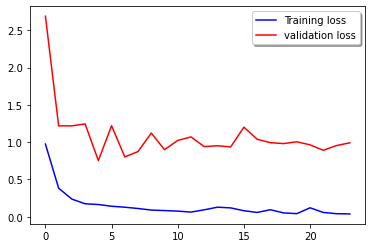

In [45]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
legend = plt.legend(loc='best', shadow=True)
plt.savefig("loss.png", bbox_inches='tight', pad_inches=0)

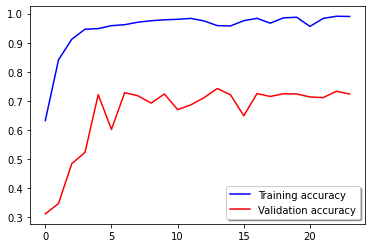

In [48]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = plt.legend(loc='best', shadow=True)
plt.savefig("acc1.png", bbox_inches='tight', pad_inches=0)

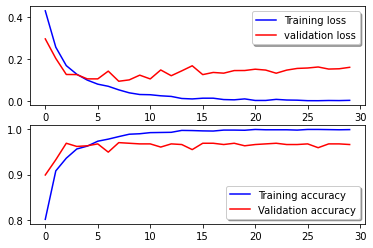

In [26]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [4]:
model = tf.keras.models.load_model('model_casia_run1.h5')

In [5]:
class_names = ['fake', 'real']

In [6]:
def predict_class(file_paths):
    for file_path in file_paths:
        image = prepare_image(file_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [12]:
fake_image_paths = ['Tp_1407_278731_138.97_198.88_314.05_553.99_person.png','Tp_71_71880_47.87_185.72_531.3_305.38_train.png']
real_image_paths = ['COCO_train2014_000000000025.jpg', '../CASIA2/Au/Au_ani_00001.jpg', '../CASIA2/Au/Au_ani_00001.jpg']

In [15]:
predict_class(real_image_paths)

Class: fake Confidence: 99.92
Class: real Confidence: 99.98
Class: real Confidence: 99.98


In [16]:
predict_class(fake_image_paths)

Class: fake Confidence: 94.43
Class: fake Confidence: 98.60


In [18]:
image = prepare_image('Tp_1407_278731_138.97_198.88_314.05_553.99_person.png')
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {y_pred_class} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: 0 Confidence: 94.43


In [20]:
y_pred.shape

(1, 2)